<a href="https://colab.research.google.com/github/Sylvariane/production_etude_de_marche/blob/master/P5_02_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Production d'une étude de marché

## 0. Paramétrage de l'environnement de travail

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm

from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [4]:
vegetaux = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/vegetaux_2017.csv')
animaux = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/animaux_2017.csv')
population = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/population_2017.csv')

## 1. Création du DataFrame et des variables nécessaires à l'étude

Les données utilisées ici sont issues du site de la FAO (http://www.fao.org/faostat/fr/#data). On a découpé nos données en trois fichiers csv contenant les informations sur les bilans alimentaires animaux et végétaux de 2017 et les informations sur la population de chaque pays en 2017. Le choix s'est porté sur l'année 2017 car il s'agit de l'année où l'on dispose de toutes les données nécessaires les plus récentes. Concernant la sélection des pays, pour éviter la présence d'un doublon, la Chine n'a pas été sélectionné en tant qu'agrégat. En revanche, les données de la Chine sont présentes à travers 4 itentités : la Chine continentale, Macao, Taïwan et Hong Kong.

### 1.1. Nettoyage des fichiers

On cherche tout d'abord la présence de données manquantes (NA) dans nos trois fichiers csv.

In [5]:
print(population.isna().sum())
print(animaux.isna().sum())
print(vegetaux.isna().sum())

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit          

On regarde ensuite s'il existe des valeurs dupliquées.

In [6]:
print(population.duplicated().sum())
print(animaux.duplicated().sum())
print(vegetaux.duplicated().sum())

0
0
0


### 1.2. Ajouts des différentes variables nécessaires à l'étude de marché

Pour notre étude de marché, il nous faut quatre variables pour chaque pays de notre échantillon : une variable reflétant la différence de population entre l'année courante et l'année antérieure (ici 2017 et 2016) exprimée en pourcentage, la proportion de protéines animales sur la proportion de protéines totales, la disponibilité alimentaire totale exprimée en calories par habitant et la disponibilité alimentaire totale exprimée en protéines par habitant.

#### 1.2.1. Ajout de la variable : croissance de la population

La variable "croissance de la population" (ou croissance_pop) représente la différence de population entre l'année 2017 et l'année 2016 et est exprimée en pourcentage.

In [7]:
population = population[['Code zone', 'Zone', 'Année', 'Valeur']]
population['croissance_pop'] = round(population.groupby('Zone')['Valeur'].pct_change() * 100,2)
population = population.loc[population['Année'] == 2017]
population = population.rename(columns={"Valeur" : "nb_habitants"})
population.head()

,Code zone,Zone,Année,nb_habitants,croissance_pop
3,2,Afghanistan,2017,36296.11,2.58
7,202,Afrique du Sud,2017,57009.76,1.43
11,3,Albanie,2017,2884.17,-0.08
15,4,Algérie,2017,41389.19,2.07
19,79,Allemagne,2017,82658.41,0.57


#### 1.2.2. Construction du DataFrame des bilans alimentaires

Avant d'ajouter les trois variables nécessaires à notre analyse, on va créer un DataFrame contenant les bilans alimentaires animaux et végétaux.

In [8]:
animaux['origine'] = 'animale'
vegetaux['origine'] = 'vegetale'
bilan_alim = animaux.append(vegetaux)
del animaux
del vegetaux
bilan_alim = bilan_alim[['Code zone', 'Zone', 'Code Produit', 'Produit', 'Élément', 'Année', 'Valeur', 'origine']]
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone', 'Code Produit', 'Produit', 'Année', 'origine'], columns= 'Élément', values='Valeur', aggfunc=np.sum).reset_index()
bilan_alim = bilan_alim.rename(columns = {'Disponibilité intérieure' : 'dispo_int', 
                                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_p_j',
                                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})
bilan_alim.head()

Élément,Code zone,Zone,Code Produit,Produit,Année,origine,dispo_kcal_p_j,dispo_kg_p,dispo_mat_g_p_j,dispo_prot_g_p_j,dispo_int
0,1,Arménie,2511,Blé et produits,2017,vegetale,1053.0,132.49,3.97,31.35,558.0
1,1,Arménie,2513,Orge et produits,2017,vegetale,4.0,0.54,0.02,0.15,114.0
2,1,Arménie,2514,Maïs et produits,2017,vegetale,68.0,7.48,0.60,2.64,58.0
3,1,Arménie,2515,Seigle et produits,2017,vegetale,1.0,0.14,0.01,0.03,1.0
4,1,Arménie,2516,Avoine,2017,vegetale,7.0,0.65,0.12,0.26,7.0


##### 1.2.2.1. Ajout de la variable : Proportion de protéines animales par rapport aux protéines totales

In [9]:
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_p_j'], aggfunc=np.sum).reset_index(level=[0])
columns = bilan_alim.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
bilan_alim.columns = new_index
bilan_alim = bilan_alim.rename(columns={'dispo_kcal_p_janimale' : 'dispo_kcal_p_j_anim',
                                        'dispo_kcal_p_jvegetale' : 'dispo_kcal_p_j_veg',
                                        'dispo_prot_g_p_janimale' : 'dispo_prot_p_j_anim',
                                        'dispo_prot_g_p_jvegetale' : 'dispo_prot_p_j_veg'})
bilan_alim['prot_anim_prot_tot'] = bilan_alim['dispo_prot_p_j_anim']/(bilan_alim['dispo_prot_p_j_anim'] + bilan_alim['dispo_prot_p_j_veg'])
bilan_alim.head()

,Code zone,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,prot_anim_prot_tot
Zone,,,,,,
Arménie,1,789.0,2283.0,44.56,52.77,0.457824
Afghanistan,2,190.0,1807.0,10.56,43.53,0.195230
Albanie,3,1094.0,2306.0,66.32,53.18,0.554979
Algérie,4,402.0,2943.0,25.70,67.15,0.276791
Angola,7,210.0,2056.0,16.47,37.62,0.304493


##### 1.2.2.2. Ajout de la variable : Disponibilité alimentaire en protéines par habitant

In [10]:
df = pd.merge(bilan_alim, population, on=['Zone', 'Code zone'])
df['nb_habitants'] = df['nb_habitants'] * 1000
df['dispo_prot_hab'] = (df['dispo_prot_p_j_anim'] + df['dispo_prot_p_j_veg']) * 365

##### 1.2.2.3. Ajout de la variable : Disponibilité alimentaire en calories par habitant

In [11]:
df['dispo_kcal_hab'] = (df['dispo_kcal_p_j_anim'] + df['dispo_kcal_p_j_veg']) * 365

### 1.3. Sélection des colonnes pour le reste de l'étude

In [12]:
df = df.rename(columns={"Zone" : 'pays'})
df = df[['pays', 'croissance_pop', 'prot_anim_prot_tot', 'dispo_prot_hab', 'dispo_kcal_hab']]
df.head()

,pays,croissance_pop,prot_anim_prot_tot,dispo_prot_hab,dispo_kcal_hab
0,Arménie,0.29,0.457824,35525.45,1121280.0
1,Afghanistan,2.58,0.195230,19742.85,728905.0
2,Albanie,-0.08,0.554979,43617.50,1241000.0
3,Algérie,2.07,0.276791,33890.25,1220925.0
4,Angola,3.38,0.304493,19742.85,827090.0


## 2. Vérification de la normalité de nos variables

### 2.1. Normalité de la distribution de la variable proportion de protéines animales sur protéines totales

Dans notre premier cas, l'hypothèse nulle (H0) est que la variable X (prot_anim_prot_tot) suit une loi normale. L'hypothèse alternative (H1) est que la variable prot_anim_prot_tot ne suit pas la loi normale.

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

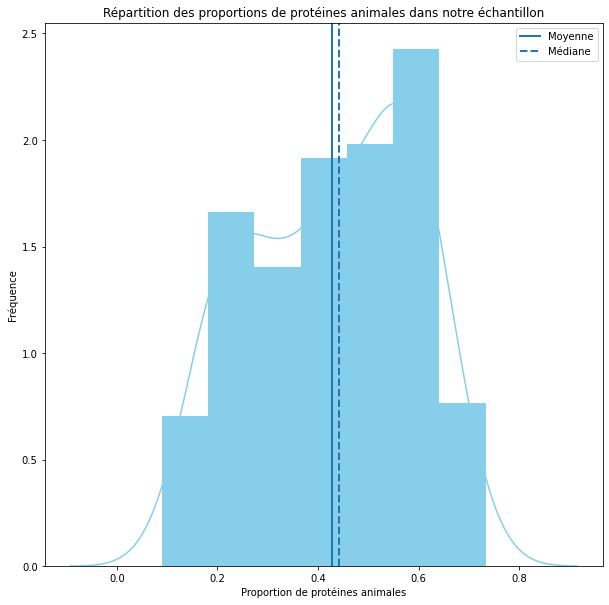

In [13]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df['prot_anim_prot_tot'],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df['prot_anim_prot_tot'].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df['prot_anim_prot_tot'].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Proportion de protéines animales')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition des proportions de protéines animales dans notre échantillon')
_ = plt.legend()

_ = plt.show()

In [14]:
ks_2samp(df["prot_anim_prot_tot"],list(np.random.normal(np.mean(df["prot_anim_prot_tot"]), np.std(df["prot_anim_prot_tot"]), 1000)))

Ks_2sampResult(statistic=0.09194117647058823, pvalue=0.1600577737891119)

On obtient une valeur D = 0.10. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient $\alpha =$ 5%. La distribution de la proportion de protéine animale par rapport à la proportion de protéine totale suit donc la loi normale. 

### 2.2. Adéquation à une loi statistique de la variable : croissance de la population

On s'intéresse ensuite à l'adéquation de la distribution de la croissance de population à la loi normale. On aura donc une hypothèse nulle (H0) où la croissance de population suit une loi normale. L'hypothèse alternative (H1) indique que notre variable d'intérêt ne suit pas la loi normale.

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

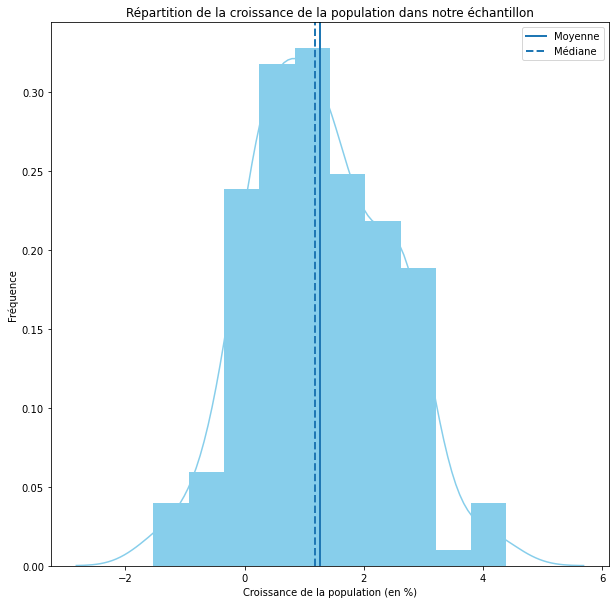

In [15]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["croissance_pop"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["croissance_pop"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["croissance_pop"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Croissance de la population (en %)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la croissance de la population dans notre échantillon')
_ = plt.legend()

_ = plt.show()

In [16]:
ks_2samp(df["croissance_pop"],list(np.random.normal(np.mean(df["croissance_pop"]), np.std(df["croissance_pop"]), 1000)))

Ks_2sampResult(statistic=0.079, pvalue=0.3066608097454109)

On obtient une valeur D = 0.06. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient $\alpha =$ 5%. La distribution de la croissance de la population suit donc la loi normale. 

### 2.3. Adéquation à une loi statistique de la variable : disponibilité alimentaire en protéines par habitant

Notre troisième test s'intéresse à la distribution de la disponibilité alimentaire en protéines par habitant. L'hypothèse nulle (H0) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H1) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

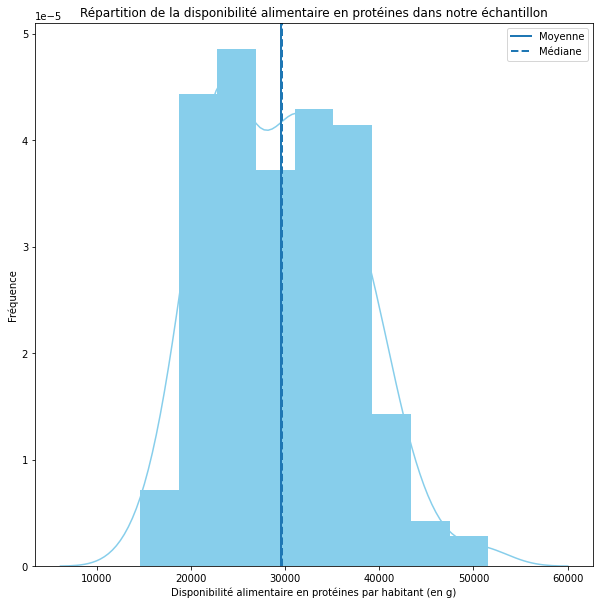

In [17]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["dispo_prot_hab"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["dispo_prot_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["dispo_prot_hab"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Disponibilité alimentaire en protéines par habitant (en g)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la disponibilité alimentaire en protéines dans notre échantillon')
_ = plt.legend()

_ = plt.show()

In [18]:
ks_2samp(df["dispo_prot_hab"],list(np.random.normal(np.mean(df["dispo_prot_hab"]), np.std(df["dispo_prot_hab"]), 1000)))

Ks_2sampResult(statistic=0.10023529411764706, pvalue=0.10004517346584885)

On obtient une valeur D = 0.08. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt169 =$ 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient $\alpha =$ 5%. La distribution de la disponibilité alimentaire en protéines par habitant suit donc la loi normale. 

### 2.4. Adéquation à une loi statistique de la variable : disponibilité alimentaire en calories par habitant

Notre quatrième test s'intéresse à la distribution de la disponibilité alimentaire en calories par habitant. L'hypothèse nulle (H0) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H1) correspond à une non-adéquation à la loi normale. 

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

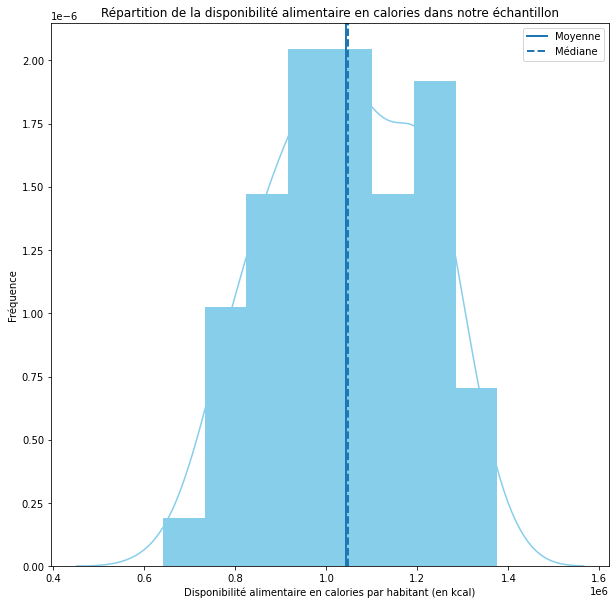

In [19]:
_ = plt.figure(figsize = (10,10))

_ = sns.distplot(df["dispo_kcal_hab"],
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
_ = plt.axvline(x=df["dispo_kcal_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2)
_ = plt.axvline(x=df["dispo_kcal_hab"].median(), label='Médiane', linestyle='--', linewidth=2)
_ = plt.xlabel('Disponibilité alimentaire en calories par habitant (en kcal)')
_ = plt.ylabel('Fréquence')
_ = plt.title('Répartition de la disponibilité alimentaire en calories dans notre échantillon')
_ = plt.legend()

_ = plt.show()

In [20]:
ks_2samp(df["dispo_kcal_hab"],list(np.random.normal(np.mean(df["dispo_kcal_hab"]), np.std(df["dispo_kcal_hab"]), 1000)))

Ks_2sampResult(statistic=0.077, pvalue=0.3358994790242015)

On obtient une valeur D = 0.05. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution de la disponibilité alimentaire en calories par habitant suit donc la loi normale. 

## 3. Clustering par une méthode de classification non-supervisée : le dendrogramme

In [21]:
df = df.set_index('pays')
df.head()

,croissance_pop,prot_anim_prot_tot,dispo_prot_hab,dispo_kcal_hab
pays,,,,
Arménie,0.29,0.457824,35525.45,1121280.0
Afghanistan,2.58,0.195230,19742.85,728905.0
Albanie,-0.08,0.554979,43617.50,1241000.0
Algérie,2.07,0.276791,33890.25,1220925.0
Angola,3.38,0.304493,19742.85,827090.0


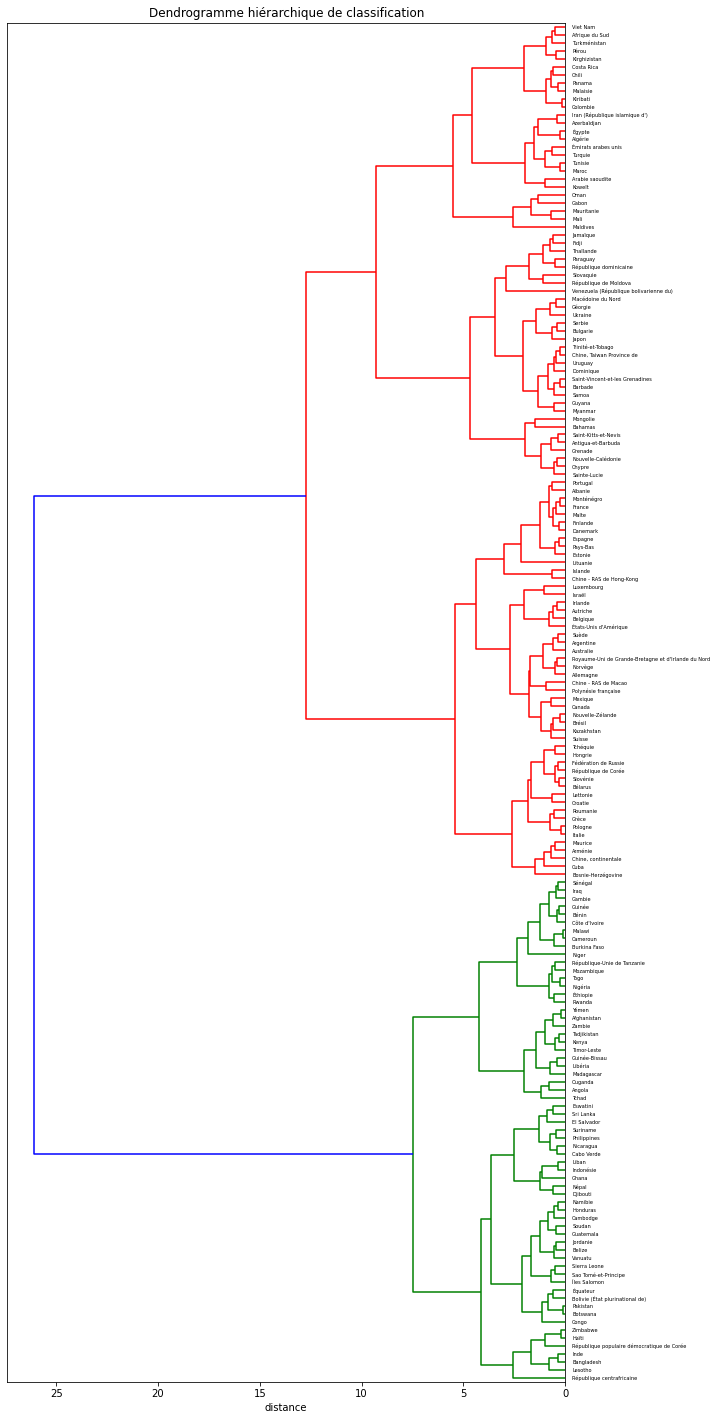

In [22]:
# préparation des données pour le clustering
X = df.values
names = df.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
_ = dendrogram(Z,
        labels = names,
        orientation = "left")
_ = plt.title('Dendrogramme hiérarchique de classification')
_ = plt.xlabel('distance')
_ = plt.savefig(f'{dir}P5_01_dendrogramme.jpg')

_ = plt.show()

In [23]:
cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : df.index.tolist(),
                             'ddg_cluster' : cluster})
data_cluster = data_cluster.sort_values(['ddg_cluster', 'pays'])
data_cluster.to_csv(f'{dir}P5_03_listepays.csv')

In [24]:
df.head()

,croissance_pop,prot_anim_prot_tot,dispo_prot_hab,dispo_kcal_hab
pays,,,,
Arménie,0.29,0.457824,35525.45,1121280.0
Afghanistan,2.58,0.195230,19742.85,728905.0
Albanie,-0.08,0.554979,43617.50,1241000.0
Algérie,2.07,0.276791,33890.25,1220925.0
Angola,3.38,0.304493,19742.85,827090.0


## 4. Analyses en composantes principales

In [25]:
n_comp = 4
data_pca = df[['croissance_pop', 'prot_anim_prot_tot', 'dispo_prot_hab', 'dispo_kcal_hab']]

X = df.values
names = df.index
features = data_pca.columns

In [26]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [27]:
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

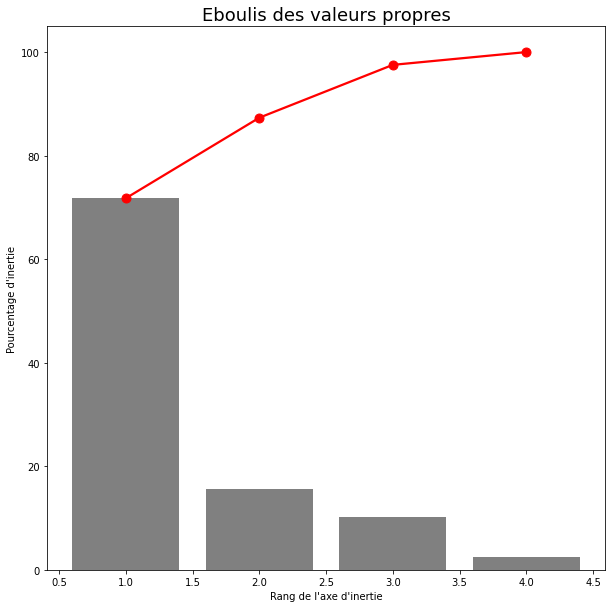

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_context('talk')

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

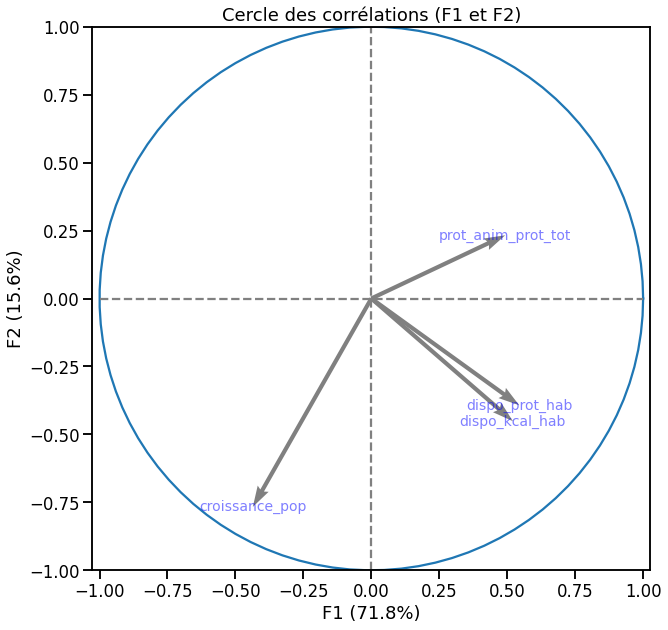

In [29]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [30]:
df = pd.merge(df, data_cluster, on='pays')
illustrative_var = df['ddg_cluster']
df = df.set_index('pays')
df.head()

,croissance_pop,prot_anim_prot_tot,dispo_prot_hab,dispo_kcal_hab,ddg_cluster
pays,,,,,
Arménie,0.29,0.457824,35525.45,1121280.0,3
Afghanistan,2.58,0.195230,19742.85,728905.0,2
Albanie,-0.08,0.554979,43617.50,1241000.0,3
Algérie,2.07,0.276791,33890.25,1220925.0,5
Angola,3.38,0.304493,19742.85,827090.0,2


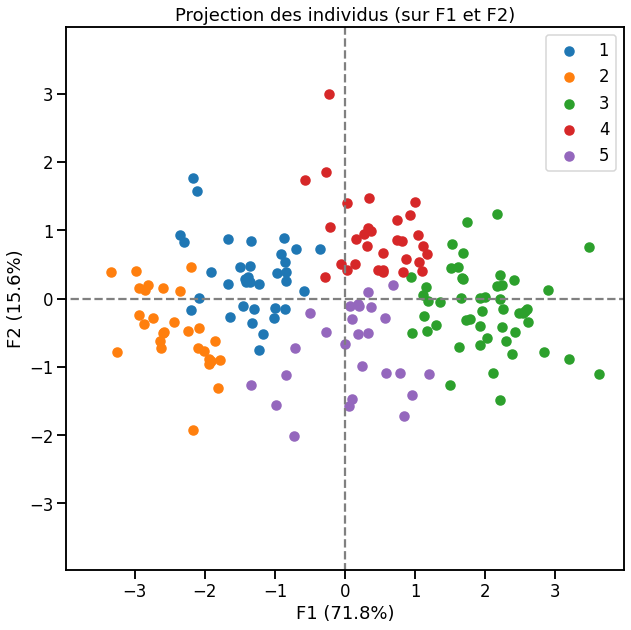

In [31]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

In [78]:
kmeans = KMeans(n_clusters=5).fit(X_projected)
centers = pca.inverse_transform(kmeans.cluster_centers_)
coord_centroids = pd.DataFrame(centers)
coord_centroids = coord_centroids.rename(columns={0 : 'croissance_pop',
                                                  1 : 'prot_anim_prot_tot', 
                                                  2 : 'dispo_prot_hab',
                                                  3 : 'dispo_kcal_hab'})
coord_centroids['cluster'] = (1,2,3,4,5)
coord_centroids = coord_centroids.set_index('cluster')
coord_centroids = coord_centroids.reset_index()
coord_centroids.to_csv(f'{dir}P5_04_coordonneescentroides.csv')

In [32]:
df['ddg_cluster'].value_counts()

3    50
1    35
4    31
2    28
5    26
Name: ddg_cluster, dtype: int64

## 5. Comparaison de moyennes entre deux clusters

In [33]:
df_2 = pd.pivot_table(df, columns='ddg_cluster', aggfunc=np.mean)
df_2 = df_2.transpose()
df_2 = df_2[['croissance_pop', 'prot_anim_prot_tot', 'dispo_kcal_hab', 'dispo_prot_hab']]
df_2

,croissance_pop,prot_anim_prot_tot,dispo_kcal_hab,dispo_prot_hab
ddg_cluster,,,,
1,1.592000,0.319439,9.143250e+05,22928.257143
2,2.797143,0.202721,8.581280e+05,21619.080357
3,0.389400,0.575290,1.225597e+06,38187.395000
4,0.370323,0.528183,1.001548e+06,28540.056452
5,1.931538,0.415372,1.110765e+06,31956.030769


On peut s'intéresser à la réalisation de statistiques inférentielles pour comparer les moyennes dans deux de nos clusters. On va s'intéresser aux clusters 1 et 2.
En effet, ces deux clusters ont l'avantage d'avoir des proportions de protéine animale représentant environ 50% indiquant qu'ils consomment autant de protéines animale que végétale.

#### 5.1. Comparaison de moyennes pour la proportion de protéines animales

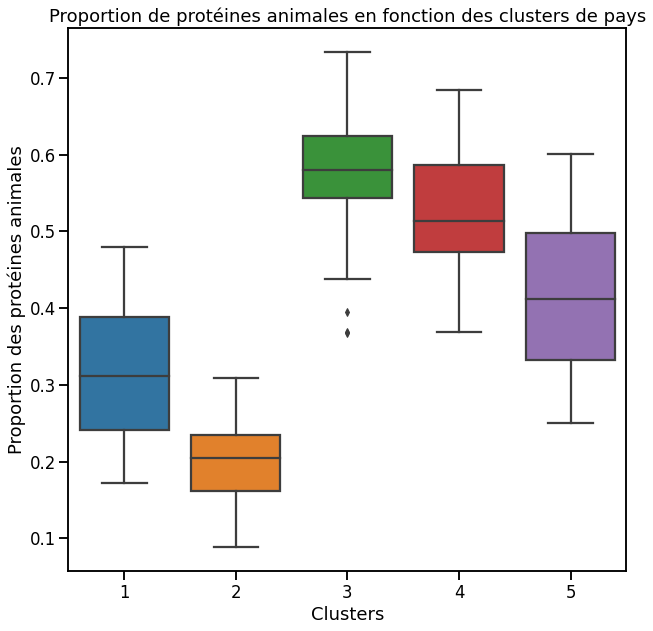

In [36]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='prot_anim_prot_tot', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Proportion des protéines animales')
_ = plt.title('Proportion de protéines animales en fonction des clusters de pays')
_ = plt.show()

Tout d'abord, on vérifie si la condition d'égalité des variances est vérifiée pour la proportion de protéines animales. On aura donc une hypothèse nulle (H0) où la variance dans le cluster 1 et la variance dans le cluster 2 sera identique et une hypothèse alternative (H1) où nos deux variances seront différentes.

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [60]:
clust1 = df[df["ddg_cluster"]==1]["prot_anim_prot_tot"]
clust2 = df[df["ddg_cluster"]==2]["prot_anim_prot_tot"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=7.256403350394008, pvalue=0.007064864093407071)

Avec une p-value = 0.007, on peut rejeter l'hypothèse nulle (H0). Nos variances ne sont donc pas égales. On effectuera ici un test non-paramétrique ; nos échantillons étant non-appariés, on effectuera un test t de Student en spécifiant que nos variances ne sont pas égales. On posera les hypothèses suivantes :

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [61]:
st.stats.ttest_ind(clust1,clust2, equal_var=False)

Ttest_indResult(statistic=6.5890764678915295, pvalue=1.5500271868273576e-08)

La p-value de notre test est égale à $1.55^-8$. On peut donc rejeter l'hypothèse nulle (H0). La proportion de protéines animales dans le cluster 1 et le cluster 2 est donc différente.

#### 5.2. Comparaisons de moyennes pour la croissance de la population

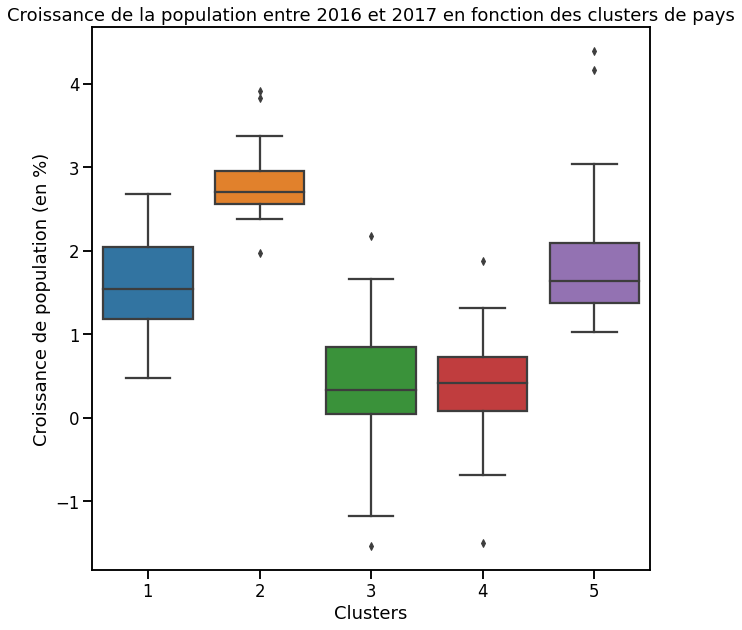

In [62]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='croissance_pop', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Croissance de population (en %)')
_ = plt.title('Croissance de la population entre 2016 et 2017 en fonction des clusters de pays')
_ = plt.show()

Ensuite, on vérifie si la condition d'égalité des variances est vérifiée pour la croissance de la population. On aura donc une hypothèse nulle (H0) où la variance dans le cluster 1 et la variance dans le cluster 2 sera identique et une hypothèse alternative (H1) où nos deux variances seront différentes.

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [64]:
clust1 = df[df["ddg_cluster"]==1]["croissance_pop"]
clust2 = df[df["ddg_cluster"]==2]["croissance_pop"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=4.6019239378453225, pvalue=0.031936097802139456)

Avec une p-value de 0.03, on peut rejeter l'hypothèse nulle (H0). On peut donc conclure que l'on n'a pas d'égalité des variances pour le cluster 1 et 2. On effectue ensuite un test t de Student en spécifiant que les variances ne sont pas égales avec les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [65]:
st.stats.ttest_ind(clust1,clust2, equal_var=False)

Ttest_indResult(statistic=-9.385909521647417, pvalue=2.5121909757602825e-13)

Le test t de comparaison de moyenne obtient une p-value de 2.51e-13. On peut donc rejeter l'hypothèse d'égalité H0. La moyenne de la croissance de population entre le cluster 1 et le cluster 2 est différente.

#### 5.3. Comparaisons de moyennes pour la disponibilité alimentaire par habitant

Avant de faire le calcul de comparaison de moyenne pour la disponibilité en protéines annuelles par habitant, on calcule la corrélation entre la disponibilité en protéines et la disponibilité en calories. En effet, il existe un lien entre les protéines et les calories. Si cette corrélation est importante, on peut se contenter de faire uniquement la comparaison de moyenne pour les protéines. 

In [66]:
x = df['dispo_prot_hab']
y = df['dispo_kcal_hab']

print('rho de pearson :', st.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df['dispo_kcal_hab']
X = df[['dispo_prot_hab']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['dispo_prot_hab'],result.params['intercept']
print('r-squared : ', (st.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.8788394301036585
indice de covariation : 1079153667.7352078
r-squared :  0.7723587439049232


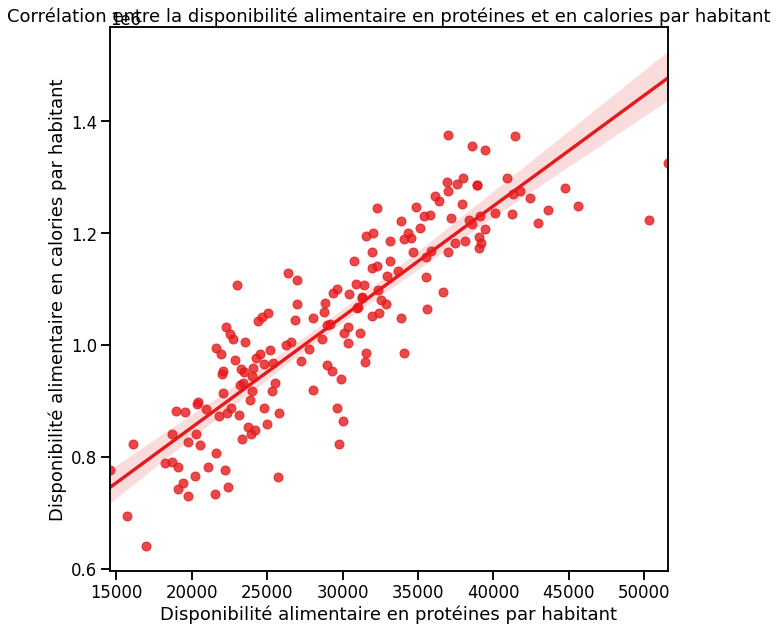

In [67]:
sns.set_context('talk')
sns.set_palette('Set1')

_ = plt.figure(figsize = (10,10))
_ = sns.regplot('dispo_prot_hab', 'dispo_kcal_hab', data=df)
_ = plt.xlabel("Disponibilité alimentaire en protéines par habitant (en g/hab)")
_ = plt.ylabel("Disponibilité alimentaire en calories par habitant (en kcal/hab)")
_ = plt.title("Corrélation entre la disponibilité alimentaire en protéines et en calories par habitant")

_ = plt.show()

Avec un coefficient de Pearson de 0.87 et un R² de 0.77, on a une corrélation linéaire positive forte entre la disponibilité alimentaire en protéines et la disponibilité alimentaire en calories.

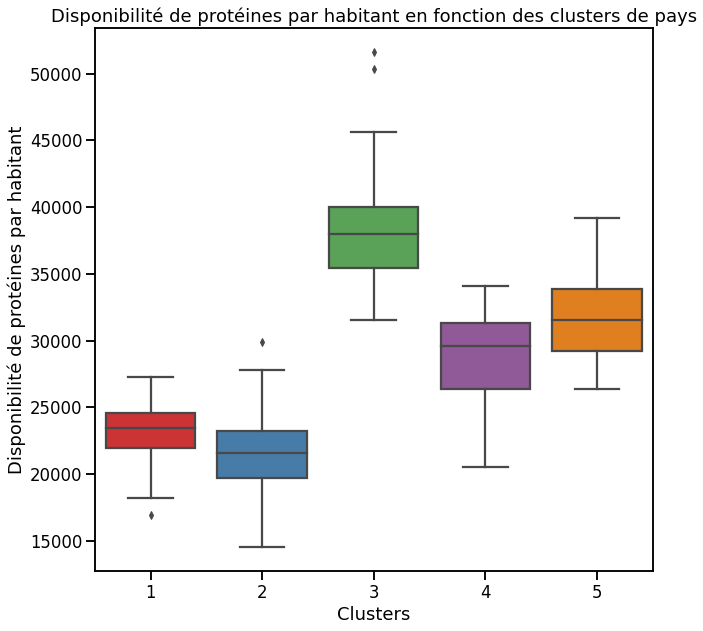

In [68]:
plt.figure(figsize=(10,10))

_ = sns.boxplot(x='ddg_cluster', y='dispo_prot_hab', data=df)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Disponibilité de protéines par habitant')
_ = plt.title('Disponibilité de protéines par habitant en fonction des clusters de pays')
_ = plt.show()

On effectue ensuite un test de Bartlett pour évaluer la variance de nos deux variables dans nos deux échantillons. On aura donc les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [70]:
clust1 = df[df["ddg_cluster"]==1]["dispo_prot_hab"]
clust2 = df[df["ddg_cluster"]==2]["dispo_prot_hab"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=2.6865897545148987, pvalue=0.10119618630809747)

Avec une p-value de 0.10, on ne peut pas rejeter l'hypothèse d'égalité des variances. On peut donc effectuer un test t de comparaison de moyennes avec les hypothèses suivantes : 

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [71]:
st.stats.ttest_ind(clust1,clust2, equal_var=True)

Ttest_indResult(statistic=1.7700311044065205, pvalue=0.08171931016117341)

Avec une p-value de 0.08, on ne peut pas rejeter l'hypothèse nulle. La moyenne de la disponibilité en protéines pour le cluster 1 et le cluster 2 est égale.